In [2]:
import pandas as pd
import glob
import os

In [3]:
def load_asd_data_with_pandas(data_path: str = "/content/drive/MyDrive/Antibody_Chekalin_Denis/asd") -> pd.DataFrame:
    """
    Загружает все parquet файлы из папки asd в один pandas DataFrame
    """
    # Получаем все parquet файлы из папки
    parquet_files = glob.glob(os.path.join(data_path, "part-*.parquet"))

    if not parquet_files:
        raise ValueError(f"Не найдено parquet файлов в папке {data_path}")

    print(f"Найдено {len(parquet_files)} parquet файлов")

    # Загружаем все файлы в список DataFrame'ов
    dataframes = []
    for file_path in parquet_files:
        # print(f"Загружаем файл: {os.path.basename(file_path)}")
        df = pd.read_parquet(file_path)
        dataframes.append(df)

    # Объединяем все DataFrame'ы в один
    combined_df = pd.concat(dataframes, ignore_index=True)

    print(f"Общий размер данных: {combined_df.shape}")
    print(f"Колонки: {list(combined_df.columns)}")

    return combined_df

# Загружаем данные
agab_df = load_asd_data_with_pandas('../asd')

Найдено 20 parquet файлов
Общий размер данных: (1227083, 11)
Колонки: ['dataset', 'heavy_sequence', 'light_sequence', 'scfv', 'affinity_type', 'affinity', 'antigen_sequence', 'confidence', 'nanobody', 'metadata', 'processed_measurement']


In [10]:
# Детальный анализ всех комбинаций affinity_type
print("=" * 60)
print("АНАЛИЗ AFFINITY_TYPE")
print("=" * 60)

print("\n1. Уникальные значения affinity_type:")
unique_types = agab_df['affinity_type'].unique()
print(f"Всего уникальных типов: {len(unique_types)}")
for i, aff_type in enumerate(unique_types, 1):
    print(f"  {i}. {aff_type}")

print("\n2. Количество записей по каждому типу:")
type_counts = agab_df['affinity_type'].value_counts()
print(type_counts)

print("\n3. Процентное распределение:")
type_percentages = agab_df['affinity_type'].value_counts(normalize=True) * 100
for aff_type, count in type_counts.items():
    percentage = type_percentages[aff_type]
    print(f"  {aff_type:25s}: {count:8,} записей ({percentage:5.2f}%)")

print("\n4. Комбинации affinity_type с dataset:")
print("\nРаспределение по dataset для каждого affinity_type:")
for aff_type in sorted(unique_types):
    subset = agab_df[agab_df['affinity_type'] == aff_type]
    dataset_dist = subset['dataset'].value_counts()
    print(f"\n  {aff_type}:")
    for dataset, count in dataset_dist.items():
        pct = (count / len(subset)) * 100
        print(f"    {dataset:15s}: {count:6,} ({pct:5.2f}%)")

print("\n5. Общая статистика:")
print(f"  Всего записей: {len(agab_df):,}")
print(f"  Записей с affinity_type: {agab_df['affinity_type'].notna().sum():,}")
print(f"  Пропущенных значений: {agab_df['affinity_type'].isna().sum():,}")

АНАЛИЗ AFFINITY_TYPE

1. Уникальные значения affinity_type:
Всего уникальных типов: 10
  1. elisa_mut_to_wt_ratio
  2. ddg
  3. bool
  4. ic_50
  5. kd
  6. fuzzy
  7. alphaseq
  8. log_enrichment
  9. -log KD
  10. delta_g

2. Количество записей по каждому типу:
affinity_type
fuzzy                    524346
bool                     336761
alphaseq                 198703
-log KD                  152401
kd                         7007
log_enrichment             3452
delta_g                    2725
ddg                         670
elisa_mut_to_wt_ratio       658
ic_50                       360
Name: count, dtype: int64

3. Процентное распределение:
  fuzzy                    :  524,346 записей (42.73%)
  bool                     :  336,761 записей (27.44%)
  alphaseq                 :  198,703 записей (16.19%)
  -log KD                  :  152,401 записей (12.42%)
  kd                       :    7,007 записей ( 0.57%)
  log_enrichment           :    3,452 записей ( 0.28%)
  delta_g       

In [ ]:
# Загружаем отфильтрованные данные из файла, созданного в 01_initial_filtering.ipynb
import os
import pandas as pd

# Путь к отфильтрованному файлу (относительно текущей директории ноутбука)
filtered_data_path = os.path.join('..', 'agab_filtered.parquet')

try:
    agab_df = pd.read_parquet(filtered_data_path, engine='pyarrow')
    print(f"Загружены отфильтрованные данные из {filtered_data_path}")
    print(f"Размер данных: {agab_df.shape}")
    print(f"Колонки: {list(agab_df.columns)}")
except FileNotFoundError:
    raise FileNotFoundError(
        f"Файл {filtered_data_path} не найден.\n"
        "Пожалуйста, сначала запустите ноутбук 01_initial_filtering.ipynb для создания отфильтрованных данных."
    )

Загружены отфильтрованные данные из ../agab_filtered.parquet
Размер данных: (1112523, 11)
Колонки: ['dataset', 'heavy_sequence', 'light_sequence', 'scfv', 'affinity_type', 'affinity', 'antigen_sequence', 'confidence', 'nanobody', 'metadata', 'processed_measurement']


# Есть ли случаи когда записи с одинаковыми  heavy_sequence light_sequence и antigen_sequence?

# Fuzzy

In [ ]:
# Поиск записей с одинаковыми heavy_sequence, light_sequence и antigen_sequence,
# у которых есть affinity_type = 'fuzzy' И другой тип affinity

# Создаём ключ для группировки
agab_df['group_key'] = agab_df['heavy_sequence'].astype(str) + '|' + \
                       agab_df['light_sequence'].astype(str) + '|' + \
                       agab_df['antigen_sequence'].astype(str)

# Находим группы, где есть fuzzy
groups_with_fuzzy = agab_df[agab_df['affinity_type'] == 'fuzzy']['group_key'].unique()
print(f"Всего групп с fuzzy: {len(groups_with_fuzzy)}")

# Находим группы, где есть НЕ fuzzy (другие типы)
groups_with_other = agab_df[agab_df['affinity_type'] != 'fuzzy']['group_key'].unique()
print(f"Всего групп с другими типами (не fuzzy): {len(groups_with_other)}")

# Находим пересечение - группы где есть И fuzzy И другие типы
groups_with_both = set(groups_with_fuzzy) & set(groups_with_other)
print(f"\nГрупп с fuzzy И другими типами одновременно: {len(groups_with_both)}")

# Фильтруем данные по этим группам
duplicates_df = agab_df[agab_df['group_key'].isin(groups_with_both)].copy()
print(f"Записей в этих группах: {len(duplicates_df)}")

# Анализ типов в дубликатах
print("\n" + "="*60)
print("Распределение affinity_type в найденных дубликатах:")
print("="*60)
print(duplicates_df['affinity_type'].value_counts())

# Показываем несколько примеров
print("\n" + "="*60)
print("Примеры групп с разными типами affinity:")
print("="*60)

example_groups = list(groups_with_both)[:5]
for i, group_key in enumerate(example_groups, 1):
    group_data = duplicates_df[duplicates_df['group_key'] == group_key]
    print(f"\n--- Пример {i} ---")
    print(f"Записей в группе: {len(group_data)}")
    print(f"Типы affinity: {list(group_data['affinity_type'].unique())}")
    print(group_data[['dataset', 'affinity_type', 'affinity', 'processed_measurement']].head(10))

Всего групп с fuzzy: 524346
Всего групп с другими типами (не fuzzy): 573637

Групп с fuzzy И другими типами одновременно: 0
Записей в этих группах: 0

Распределение affinity_type в найденных дубликатах:
Series([], Name: count, dtype: int64)

Примеры групп с разными типами affinity:


# AlphaSeq

In [12]:
alphaseq_df = agab_df[agab_df['affinity_type'] == 'alphaseq'].copy()

In [13]:
alphaseq_df.head(5)

,dataset,heavy_sequence,light_sequence,scfv,affinity_type,affinity,antigen_sequence,confidence,nanobody,metadata,processed_measurement
24228,alphaseq,QVQLQESGGGLVQAGGSLRLSCAASAFTFSSYAMGWFRQAPGKERE...,,False,alphaseq,NaN,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,high,True,"{'target_name': 'sars-cov2_rbd', 'target_pdb':...",nan
24229,alphaseq,QVQLQESGGGLVQAGGSLRLSCAASARTFSEYAMGWFRQAPGKERE...,,False,alphaseq,1.5668465652316428,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,high,True,"{'target_name': 'sars-cov2_rbd', 'target_pdb':...",1.5668465652316428
24230,alphaseq,QVQLQESGGGLVQAGGSLRLSCAASCRTFSESAMGWFRQAPNAKER...,,False,alphaseq,1.6335963891137304,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,high,True,"{'target_name': 'sars-cov2_rbd', 'target_pdb':...",1.6335963891137304
24231,alphaseq,QVQLQESGGGLVQAGGSLRLSCAASDNHFTEYAMGWFRQAPGKEKE...,,False,alphaseq,1.7200503987547329,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,high,True,"{'target_name': 'sars-cov2_rbd', 'target_pdb':...",1.7200503987547329
24232,alphaseq,QVQLQESGGGLVQAGGSLRLSCAASDRALSEVAMGWFRQAPGKELE...,,False,alphaseq,1.998809003507617,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,high,True,"{'target_name': 'sars-cov2_rbd', 'target_pdb':...",1.998809003507617


In [8]:
print(alphaseq_df.head(1)['metadata'].iloc[0])

{'target_name': 'sars-cov2_rbd', 'target_pdb': '', 'target_uniprot': '', 'source_url': 'https://www.biorxiv.org/content/10.1101/2024.11.11.622872v1.full', 'heavy_riot_numbering': {'cdr1_aa': 'AFTFSSYA', 'cdr2_aa': 'ISWSGDCT', 'cdr3_aa': 'AAAGIWTVVSEWDYDYDDT', 'sequence_alignment_aa': 'QVQLQESGGGLVQAGGSLRLSCAASAFTFSSYAMGWFRQAPGKEREFVATISWSGDCTYYTDSVKRRFTISRDNAKNTVFLQMNSLKPDDTAVYYCAAAGIWTVVSEWDYDYDDTWGQGTQVTVSS'}, 'light_riot_numbering': {'cdr1_aa': None, 'cdr2_aa': None, 'cdr3_aa': None, 'sequence_alignment_aa': None}}


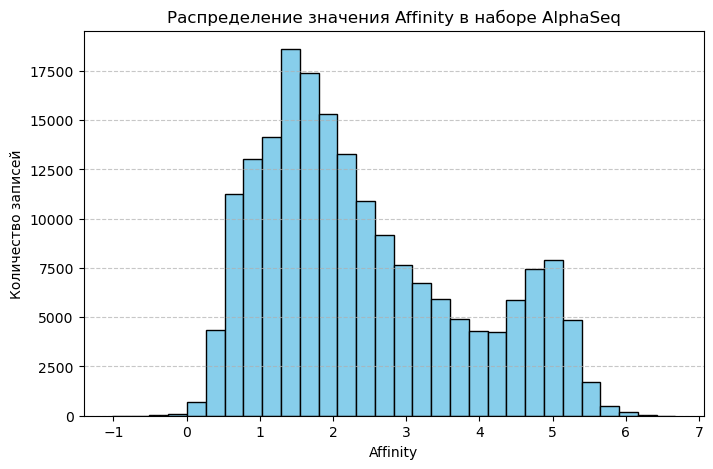

In [14]:
# Строим распределение значения поля affinity (предварительно исключая пропуски/NaN)
affinity_values = pd.to_numeric(alphaseq_df['affinity'], errors='coerce').dropna()

plt.figure(figsize=(8, 5))
plt.hist(affinity_values, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Affinity')
plt.ylabel('Количество записей')
plt.title('Распределение значения Affinity в наборе AlphaSeq')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Порог < 2 для определения связывающихся (KD < 100 nM)  
[Чат с этим вопросом](https://chatgpt.com/share/6959021d-cd2c-8008-9c5a-d52db6591fb4)  
[huggingface alphaseq](https://huggingface.co/datasets/aalphabio/open-alphaseq#:~:text=for%20negative%20controls.-,alphaseq_affinity,-Pairwise%20interaction%20affinity) 

создать файл с фильтрацией датасета
сделать фильтр выше по уже прописанным критериям 

# log-enrichment

In [19]:
agab_df.head()

,dataset,heavy_sequence,light_sequence,scfv,affinity_type,affinity,antigen_sequence,confidence,nanobody,metadata,processed_measurement
0,abdesign,QVQLVQSGAEVQKPGASVKVSCKASGYTFASYDINWVRQATGQGLE...,DIQLTQSPSSLSASVGDSVTITCRASQGFGNYLAWYQQRPGKVPEV...,False,elisa_mut_to_wt_ratio,0.03900940322,VWKDADTTLFCASDAKAHETEVHNVWATHACVPTDPNPQEIHLENV...,very_high,False,"{'target_name': '', 'target_pdb': '6mfp', 'tar...",0.03900940322
1,ab-bind,QVQLQESGPGLVAPSQSLSITCTVSGFSLTGAGVNWVRQPPGKGLE...,DIVLTQSPASLSASVGETVTITCRASGNIHNYLAWYQQKQGKSPQL...,False,ddg,1.1,KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRN...,very_high,False,"{'target_name': '', 'target_pdb': '1vfb', 'tar...",0.7800730860179147
2,skempiv2,QVQLQESGPGLVAPSQSLSITCTVSGFSLTGAGVNWVRQPPGKGLE...,DIVLTQSPASLSASVGETVTITCRASGNIHNYLAWYQQKQGKSPQL...,False,ddg,0.4601461720358293,KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRN...,very_high,False,"{'target_name': '', 'target_pdb': '1vfb', 'tar...",0.7800730860179147
3,abdesign,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYWINWVRQAPGQGLE...,DIVMTQSPDSLAVSLGERATINCKSSQSLWDSGNQKNFLTWYQQKP...,False,elisa_mut_to_wt_ratio,1.008535785,WNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRMSPSNQTD...,very_high,False,"{'target_name': '', 'target_pdb': '6xkr', 'tar...",1.008535785
4,abdesign,VQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLEW...,EIVLTQSPATLSLSPGERATLSCRASKGVSTSGYSYLHWYQQKPGQ...,False,elisa_mut_to_wt_ratio,0.7620531622,PWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRMSPSNQT...,very_high,False,"{'target_name': '', 'target_pdb': '5ggs', 'tar...",0.7620531622


In [24]:
agab_df['affinity_type'].value_counts()

affinity_type
fuzzy                    524346
bool                     336761
alphaseq                 198703
-log KD                  152401
kd                         7007
log_enrichment             3452
delta_g                    2725
ddg                         670
elisa_mut_to_wt_ratio       658
ic_50                       360
Name: count, dtype: int64

In [26]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Предположим, что agab_df уже загружен в памяти

# --- 1️⃣ Фильтрация нужных строк ---
# Оставляем только строки, где есть log_enrichment
enrich_df = agab_df[agab_df["affinity_type"] == "log_enrichment"].copy()

if len(enrich_df) == 0:
    raise ValueError("Не найдено записей с affinity_type == 'log_enrichment'")

print(f"Найдено записей с log_enrichment: {len(enrich_df)}")

# Преобразуем в float, удаляя невалидные значения
enrich_df["log_enrichment"] = pd.to_numeric(enrich_df["processed_measurement"], errors='coerce')
enrich_df = enrich_df[enrich_df["log_enrichment"].notna()].copy()

if len(enrich_df) == 0:
    raise ValueError("Не найдено валидных значений log_enrichment после преобразования")

print(f"Валидных записей с log_enrichment: {len(enrich_df)}")

# --- 2️⃣ Собираем пары log_enrichment ↔ KD ---
# Если KD есть как отдельный тип измерения — извлекаем
kd_df = agab_df[agab_df["affinity_type"].isin(["kd"])].copy()

if len(kd_df) == 0:
    raise ValueError("Не найдено записей с affinity_type в ['kd', 'KD', 'Kd']")

print(f"Найдено записей с KD: {len(kd_df)}")

# Преобразуем в float, удаляя невалидные значения
kd_df["KD_nM"] = pd.to_numeric(kd_df["processed_measurement"], errors='coerce')
kd_df = kd_df[kd_df["KD_nM"].notna()].copy()
kd_df = kd_df[kd_df["KD_nM"] > 0].copy()  # KD должен быть положительным

if len(kd_df) == 0:
    raise ValueError("Не найдено валидных значений KD после преобразования")

print(f"Валидных записей с KD: {len(kd_df)}")

# Присоединяем по heavy_sequence + light_sequence
merged = pd.merge(
    enrich_df,
    kd_df,
    on=["heavy_sequence", "light_sequence"],
    suffixes=("_enrich", "_kd")
)

if len(merged) == 0:
    raise ValueError(
        f"Не найдено совпадений между log_enrichment и KD по ключам "
        f"['heavy_sequence', 'light_sequence'].\n"
        f"Уникальных комбинаций в enrich_df: {enrich_df[['heavy_sequence', 'light_sequence']].drop_duplicates().shape[0]}\n"
        f"Уникальных комбинаций в kd_df: {kd_df[['heavy_sequence', 'light_sequence']].drop_duplicates().shape[0]}"
    )

print(f"Найдено совпадений (пар log_enrichment ↔ KD): {len(merged)}")

# --- 3️⃣ Преобразуем KD в log10 шкалу ---
merged["log10_KD"] = np.log10(merged["KD_nM"])

# --- 4️⃣ Регрессия: log10(KD) = a - b * log_enrichment ---
X = sm.add_constant(merged["log_enrichment"])  # добавляем константу для a
y = merged["log10_KD"]
model = sm.OLS(y, X).fit()

a = model.params["const"]
b = -model.params["log_enrichment"]  # минус, потому что связь обратная

print(f"\nЭмпирическая аппроксимация: log10(KD) ≈ {a:.3f} - {b:.3f} × log_enrichment")
print("\n" + "="*60)
print(model.summary())

# --- 5️⃣ Визуализация ---
plt.figure(figsize=(10, 6))
plt.scatter(merged["log_enrichment"], merged["log10_KD"], alpha=0.5, label="data")
x_line = np.linspace(merged["log_enrichment"].min(), merged["log_enrichment"].max(), 100)
y_line = model.params["const"] + model.params["log_enrichment"] * x_line
plt.plot(x_line, y_line, label="fit", linewidth=2, color='red')
plt.xlabel("log_enrichment")
plt.ylabel("log10(KD [nM])")
plt.title(f"Корреляция log_enrichment и log10(KD)\n(n={len(merged)} пар)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Найдено записей с log_enrichment: 3452
Валидных записей с log_enrichment: 3452
Найдено записей с KD: 7007
Валидных записей с KD: 6988


ValueError: Не найдено совпадений между log_enrichment и KD по ключам ['heavy_sequence', 'light_sequence'].
Уникальных комбинаций в enrich_df: 3452
Уникальных комбинаций в kd_df: 6986

In [31]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --- 1️⃣ Фильтрация нужных строк ---
# Оставляем только строки, где есть elisa_mut_to_wt_ratio
elisa_df = agab_df[agab_df["affinity_type"] == "elisa_mut_to_wt_ratio"].copy()

if len(elisa_df) == 0:
    raise ValueError("Не найдено записей с affinity_type == 'elisa_mut_to_wt_ratio'")

print(f"Найдено записей с elisa_mut_to_wt_ratio: {len(elisa_df)}")

# Преобразуем в float, удаляя невалидные значения
elisa_df["elisa_ratio"] = pd.to_numeric(elisa_df["processed_measurement"], errors='coerce')
elisa_df = elisa_df[elisa_df["elisa_ratio"].notna()].copy()
elisa_df = elisa_df[elisa_df["elisa_ratio"] > 0].copy()  # ratio должен быть положительным

if len(elisa_df) == 0:
    raise ValueError("Не найдено валидных значений elisa_mut_to_wt_ratio после преобразования")

print(f"Валидных записей с elisa_mut_to_wt_ratio: {len(elisa_df)}")

# --- 2️⃣ Собираем пары elisa_mut_to_wt_ratio ↔ KD ---
# Если KD есть как отдельный тип измерения — извлекаем
kd_df = agab_df[agab_df["affinity_type"].isin(["kd"])].copy()

if len(kd_df) == 0:
    raise ValueError("Не найдено записей с affinity_type == 'kd'")

print(f"Найдено записей с KD: {len(kd_df)}")

# Преобразуем в float, удаляя невалидные значения
kd_df["KD_nM"] = pd.to_numeric(kd_df["processed_measurement"], errors='coerce')
kd_df = kd_df[kd_df["KD_nM"].notna()].copy()
kd_df = kd_df[kd_df["KD_nM"] > 0].copy()  # KD должен быть положительным

if len(kd_df) == 0:
    raise ValueError("Не найдено валидных значений KD после преобразования")

print(f"Валидных записей с KD: {len(kd_df)}")

# Присоединяем по heavy_sequence + light_sequence
merged = pd.merge(
    elisa_df,
    kd_df,
    on=["heavy_sequence", "light_sequence"],
    suffixes=("_elisa", "_kd")
)

if len(merged) == 0:
    raise ValueError(
        f"Не найдено совпадений между elisa_mut_to_wt_ratio и KD по ключам "
        f"['heavy_sequence', 'light_sequence'].\n"
        f"Уникальных комбинаций в elisa_df: {elisa_df[['heavy_sequence', 'light_sequence']].drop_duplicates().shape[0]}\n"
        f"Уникальных комбинаций в kd_df: {kd_df[['heavy_sequence', 'light_sequence']].drop_duplicates().shape[0]}"
    )

print(f"Найдено совпадений (пар elisa_mut_to_wt_ratio ↔ KD): {len(merged)}")

# --- 3️⃣ Преобразуем KD в log10 шкалу ---
merged["log10_KD"] = np.log10(merged["KD_nM"])

# --- 4️⃣ Регрессия: log10(KD) = a + b * elisa_ratio ---
X = sm.add_constant(merged["elisa_ratio"])  # добавляем константу для a
y = merged["log10_KD"]
model = sm.OLS(y, X).fit()

a = model.params["const"]
b = model.params["elisa_ratio"]

print(f"\nЭмпирическая аппроксимация: log10(KD) ≈ {a:.3f} + {b:.3f} × elisa_mut_to_wt_ratio")
print("\n" + "="*60)
print(model.summary())

# --- 5️⃣ Визуализация ---
plt.figure(figsize=(10, 6))
plt.scatter(merged["elisa_ratio"], merged["log10_KD"], alpha=0.5, label="data")
x_line = np.linspace(merged["elisa_ratio"].min(), merged["elisa_ratio"].max(), 100)
y_line = model.params["const"] + model.params["elisa_ratio"] * x_line
plt.plot(x_line, y_line, label="fit", linewidth=2, color='red')
plt.xlabel("elisa_mut_to_wt_ratio")
plt.ylabel("log10(KD [nM])")
plt.title(f"Корреляция elisa_mut_to_wt_ratio и log10(KD)\n(n={len(merged)} пар)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Найдено записей с elisa_mut_to_wt_ratio: 658
Валидных записей с elisa_mut_to_wt_ratio: 658
Найдено записей с KD: 7007
Валидных записей с KD: 6988


ValueError: Не найдено совпадений между elisa_mut_to_wt_ratio и KD по ключам ['heavy_sequence', 'light_sequence'].
Уникальных комбинаций в elisa_df: 658
Уникальных комбинаций в kd_df: 6986

In [35]:
elisa_df.sample(10)

,dataset,heavy_sequence,light_sequence,scfv,affinity_type,affinity,antigen_sequence,confidence,nanobody,metadata,processed_measurement,elisa_ratio
795313,abdesign,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYWINWVRQAPGQGLE...,DIVMTQSPDSLAVSLGERATINCKSSQSLWDSGNQKNFLTWYQQKP...,False,elisa_mut_to_wt_ratio,1.060141422,WNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRMSPSNQTD...,very_high,False,"{'target_name': '', 'target_pdb': '6xkr', 'tar...",1.060141422,1.060141
244680,abdesign,VQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLEW...,EIVLTQSPATLSLSPGERATLSCRASKGVSTSGYSYLHWYQQKPGQ...,False,elisa_mut_to_wt_ratio,0.7299539171,PWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRMSPSNQT...,very_high,False,"{'target_name': '', 'target_pdb': '5ggs', 'tar...",0.7299539171,0.729954
735097,abdesign,DVQLVESGGGVVRPGESLRLSCAASGFTFSSYDMNWVRQAPGEGLE...,ETVLTQSPGTLTLSPGERATLTCRASQSVYTYLAWYQEKPGQAPRL...,False,elisa_mut_to_wt_ratio,0.981657179,EEELQVIQPDKSVLVAAGETATLRCTATSLIPVGPIQWFRGAGPGR...,very_high,False,"{'target_name': '', 'target_pdb': '6nms', 'tar...",0.981657179,0.981657
122010,abdesign,VQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLEW...,DIQMTQSPSSLSASVGDRVTITCRASQDIPRSISGYVAWYQQKPGK...,False,elisa_mut_to_wt_ratio,0.9390901702,EVVKFMDVYQRSYCHPIETLVDIFQEYPDEIEYIFKPSCVPLMRCG...,very_high,False,"{'target_name': '', 'target_pdb': '7kf0', 'tar...",0.9390901702,0.939090
1103405,abdesign,QVQLVQSGAEVKKPGASVTVSCQASGYTFTNYYVHWVRQAPGQGLQ...,EIVLTQSPATLSVSPGERATLSCRASQSVRSNLAWYQQRPGQAPRL...,False,elisa_mut_to_wt_ratio,0.1096412009,WKDADTTLFCASDAKAHETEVHNVWATHACVPTDPNPQEIHLENVT...,very_high,False,"{'target_name': '', 'target_pdb': '5f9w', 'tar...",0.1096412009,0.109641
183478,abdesign,VQLVQSGVEVKKPGASVKVSCKASGYTFTNYYMYWVRQAPGQGLEW...,EIVLTQSPATLSLSPGERATLSCRASKGVSTSGYSYLHWYQQKPGQ...,False,elisa_mut_to_wt_ratio,0.9203602849,PWNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRMSPSNQT...,very_high,False,"{'target_name': '', 'target_pdb': '5ggs', 'tar...",0.9203602849,0.920360
59102,abdesign,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYWINWVRQAPGQGLE...,DIVMTQSPDSLAVSLGERATINCKSSQSLWDSGNQKNFLTWYQQKP...,False,elisa_mut_to_wt_ratio,1.115273365,WNPPTFSPALLVVTEGDNATFTCSFSNTSESFVLNWYRMSPSNQTD...,very_high,False,"{'target_name': '', 'target_pdb': '6xkr', 'tar...",1.115273365,1.115273
735076,abdesign,QVQLVQSGAEVKKPGASVTVSCQASGYTFTNYYVHWVRQAPGQGLQ...,EIVLTQSPATLSVSPGERATLSCRASQSVRSNLAWYQQRPGQAPRL...,False,elisa_mut_to_wt_ratio,0.02723834832,WKDADTTLFCASDAKAHETEVHNVWATHACVPTDPNPQEIHLENVT...,very_high,False,"{'target_name': '', 'target_pdb': '5f9w', 'tar...",0.02723834832,0.027238
550739,abdesign,EVQLVESGGGLVQPGGSLRLSCAASGYTFTNYGMNWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCSASQDISNYLNWYQQKPGKAPKV...,False,elisa_mut_to_wt_ratio,1.156380455,VVKFMDVYQRSYCHPIETLVDIFQEYPDEIEYIFKPSCVPLMRCGG...,very_high,False,"{'target_name': '', 'target_pdb': '1bj1', 'tar...",1.156380455,1.156380
304928,abdesign,QVQLVESGGGVVQPGRSLRLSCAASGFTFSSYGMHWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQSINSYLDWYQQKPGKAPKL...,False,elisa_mut_to_wt_ratio,0.8974177131,KAMHVAQPAVVLASSRGIASFVCEYASPGKATEVRVTVLRQADSQV...,very_high,False,"{'target_name': '', 'target_pdb': '5ggv', 'tar...",0.8974177131,0.897418


# ddG

In [39]:
ddg_df = agab_df[agab_df["affinity_type"] == "ddg"].copy()

In [40]:
ddg_df.sample(10)

,dataset,heavy_sequence,light_sequence,scfv,affinity_type,affinity,antigen_sequence,confidence,nanobody,metadata,processed_measurement
1042401,ab-bind,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQDIPRSIAGYVAWYQQKPGK...,False,ddg,-0.2,TQVCTGTDMKLRLPASPETHLDMLRHLYQGCQVVQGNLELTYLPTN...,very_high,False,"{'target_name': '', 'target_pdb': '3be1', 'tar...",-0.2
919199,skempiv2,QVQLVQSGSGVKKPGASVRVSCWTSEDIFERTELIHWVRQAPGQGL...,EIVLTQSPGTLSLSPGETASLSCTAASYGHMTWYQKKPGQPPKLLI...,False,ddg,-0.6151596021122041,VWKDADTTLFCASDAKAHETEVHNVWATHACVPTDPNPQEIHLENV...,very_high,False,"{'target_name': '', 'target_pdb': '3se9', 'tar...",-0.6151596021122041
427006,ab-bind,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQDIPASISGYVAWYQQKPGK...,False,ddg,-0.2,TQVCTGTDMKLRLPASPETHLDMLRHLYQGCQVVQGNLELTYLPTN...,very_high,False,"{'target_name': '', 'target_pdb': '3be1', 'tar...",-0.2
550703,ab-bind,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQDVSTAVAWYQQKPGKAPKL...,False,ddg,0.06,TQVCTGTDMKLRLPASPETHLDMLRHLYQGCQVVQGNLELTYLPTN...,very_high,False,"{'target_name': '', 'target_pdb': '1n8z', 'tar...",0.06333158691717836
735043,skempiv2,EVQLVESGGGLVQPGGSLRLSCAASGYTFTNYGMNWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCSASQDISNYLNWYQQKPGKAPKV...,False,ddg,0.7896526937286235,VVKFMDVYQRSYCHPIETLVDIFQEYPDEIEYIFKPSCVPLMRCGG...,very_high,False,"{'target_name': '', 'target_pdb': '1bj1', 'tar...",0.7896526937286235
735103,skempiv2,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRYTMSWVRQAPGKGLE...,QIQLTQSPSSLSASVGDRVTITCSASSQVNHMFWYQQKPGKAPKPW...,False,ddg,-0.0420166863808608,QLDIVIVLDGSNSIYPWESVIAFLNDLLKRMDIGPKQTQVGIVQYG...,very_high,False,"{'target_name': '', 'target_pdb': '2b2x', 'tar...",0.02405465412265495
550705,skempiv2,QVQLQESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,DIVLTQSPASLSASVGETVTITCRASGNIHNYLAWYQQKQGKSPQL...,False,ddg,0.7975416432882794,KVFGRCELAAAMKRHGLDNYRGYSLGNWVCAAKFESNFNTQATNRN...,very_high,False,"{'target_name': '', 'target_pdb': '1vfb', 'tar...",0.7975416432882794
183531,skempiv2,QVQLVQSGGQMKKPGESMRISCRASGYEFIDCTLNWIRLAPGKRPE...,VLTQSPGTLSLSPGETAIISCRTSQYGSLAWYQQRPGQAPRLVIYS...,False,ddg,1.3199504832847853,VWKDADTTLFCASDAKAHETEVHNVWATHACVPTDPNPQEIHLENV...,very_high,False,"{'target_name': '', 'target_pdb': '3ngb', 'tar...",1.3199504832847853
981341,skempiv2,EVQLVESGGGLVQPGGSLRLSCAASGYTFTNYGMNWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCSASQDISNYLNWYQQKPGKAPKV...,False,ddg,4.438761515768912,VVKFMDVYQRSYCHPIETLVDIFQEYPDEIEYIFKPSCVPLMRCGG...,very_high,False,"{'target_name': '', 'target_pdb': '1bj1', 'tar...",4.438761515768912
735050,skempiv2,QLQLQESGPGLVKPSETLSLTCTVSGASIDRSTYYWGWIRQPPGKG...,LTQPPSASGTPGQRVTISCSGSSSNIETNYVSWYQQFPGTAPKLLI...,False,ddg,1.460029953414374,KYPYRVCSMAQGTDLIRFERNIVCTSMLDEGIMVVYKRNIVAHTFK...,very_high,False,"{'target_name': '', 'target_pdb': '5c6t', 'tar...",1.460029953414374


In [ ]:
agab_df.groupby("affinity_type")["antigen_sequence"].nunique().sort_values(ascending=False)

affinity_type
bool                     9197
delta_g                   594
ddg                        22
elisa_mut_to_wt_ratio      13
kd                         11
ic_50                      10
-log KD                     5
alphaseq                    3
log_enrichment              2
fuzzy                       1
Name: antigen_sequence, dtype: int64

# ic_50

In [5]:
agab_df[agab_df["affinity_type"] == "ic_50"].sample(10)[['dataset', 'affinity_type', 'affinity', 'processed_measurement']]

,dataset,affinity_type,affinity,processed_measurement
305166,dlgo,ic_50,0.003,0.003
981592,dlgo,ic_50,0.075,0.075
122253,dlgo,ic_50,0.004,0.004
427226,dlgo,ic_50,0.065,0.065
795617,dlgo,ic_50,0.008,0.008
795622,dlgo,ic_50,0.003,0.003
735312,dlgo,ic_50,0.627,0.627
305159,dlgo,ic_50,0.071,0.071
366101,dlgo,ic_50,1.657,1.657
858452,dlgo,ic_50,0.007,0.007


In [4]:
agab_df[agab_df["affinity_type"] == "ic_50"]["antigen_sequence"].nunique()

10